In [1]:
import matplotlib.pyplot as plt
from models import get_models
import torch
from defs import *
from diffusers import DDPMScheduler, DDPMPipeline
import numpy as np
from minepi import Skin
from PIL import Image
import math

/root/anaconda3/envs/album/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Definding seed and device

In [8]:
DEVICE = 'cuda:0'
SEED = 100231
MODEL_PATH = "./weights"
BATCH_SIZE = 40

## Getting Diffusion model

In [9]:
model = get_models(IMSIZE).to(DEVICE)
model = model.from_pretrained(MODEL_PATH)
model.sample_size = 64
model = model.to(DEVICE)
model.eval()
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS, beta_schedule="squaredcos_cap_v2")

pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
generator = torch.Generator(device=DEVICE)
generator = generator.manual_seed(SEED)

## Generate 128x128 images

In [10]:
images = pipeline(
    batch_size=BATCH_SIZE,
    generator=generator,
    output_type=None
).images

100%|██████████| 1000/1000 [00:43<00:00, 22.81it/s]


In [11]:
def postprocess(images:np.ndarray, opacity_th:float) -> np.ndarray:
    """preprocessing output of the model

    Args:
        images (np.ndarray): output of the model [batch_size, H, W, C]
        opacity_th (float): Threshold for opacity.

    Returns:
        np.ndarray: processed numpy array of shape [batch_size, H, W, C]
    """
    images[..., - 1] = (images[..., - 1]>opacity_th)* images[..., - 1]
    images = ((images)*255)
    images = images.astype('uint8')
    return images


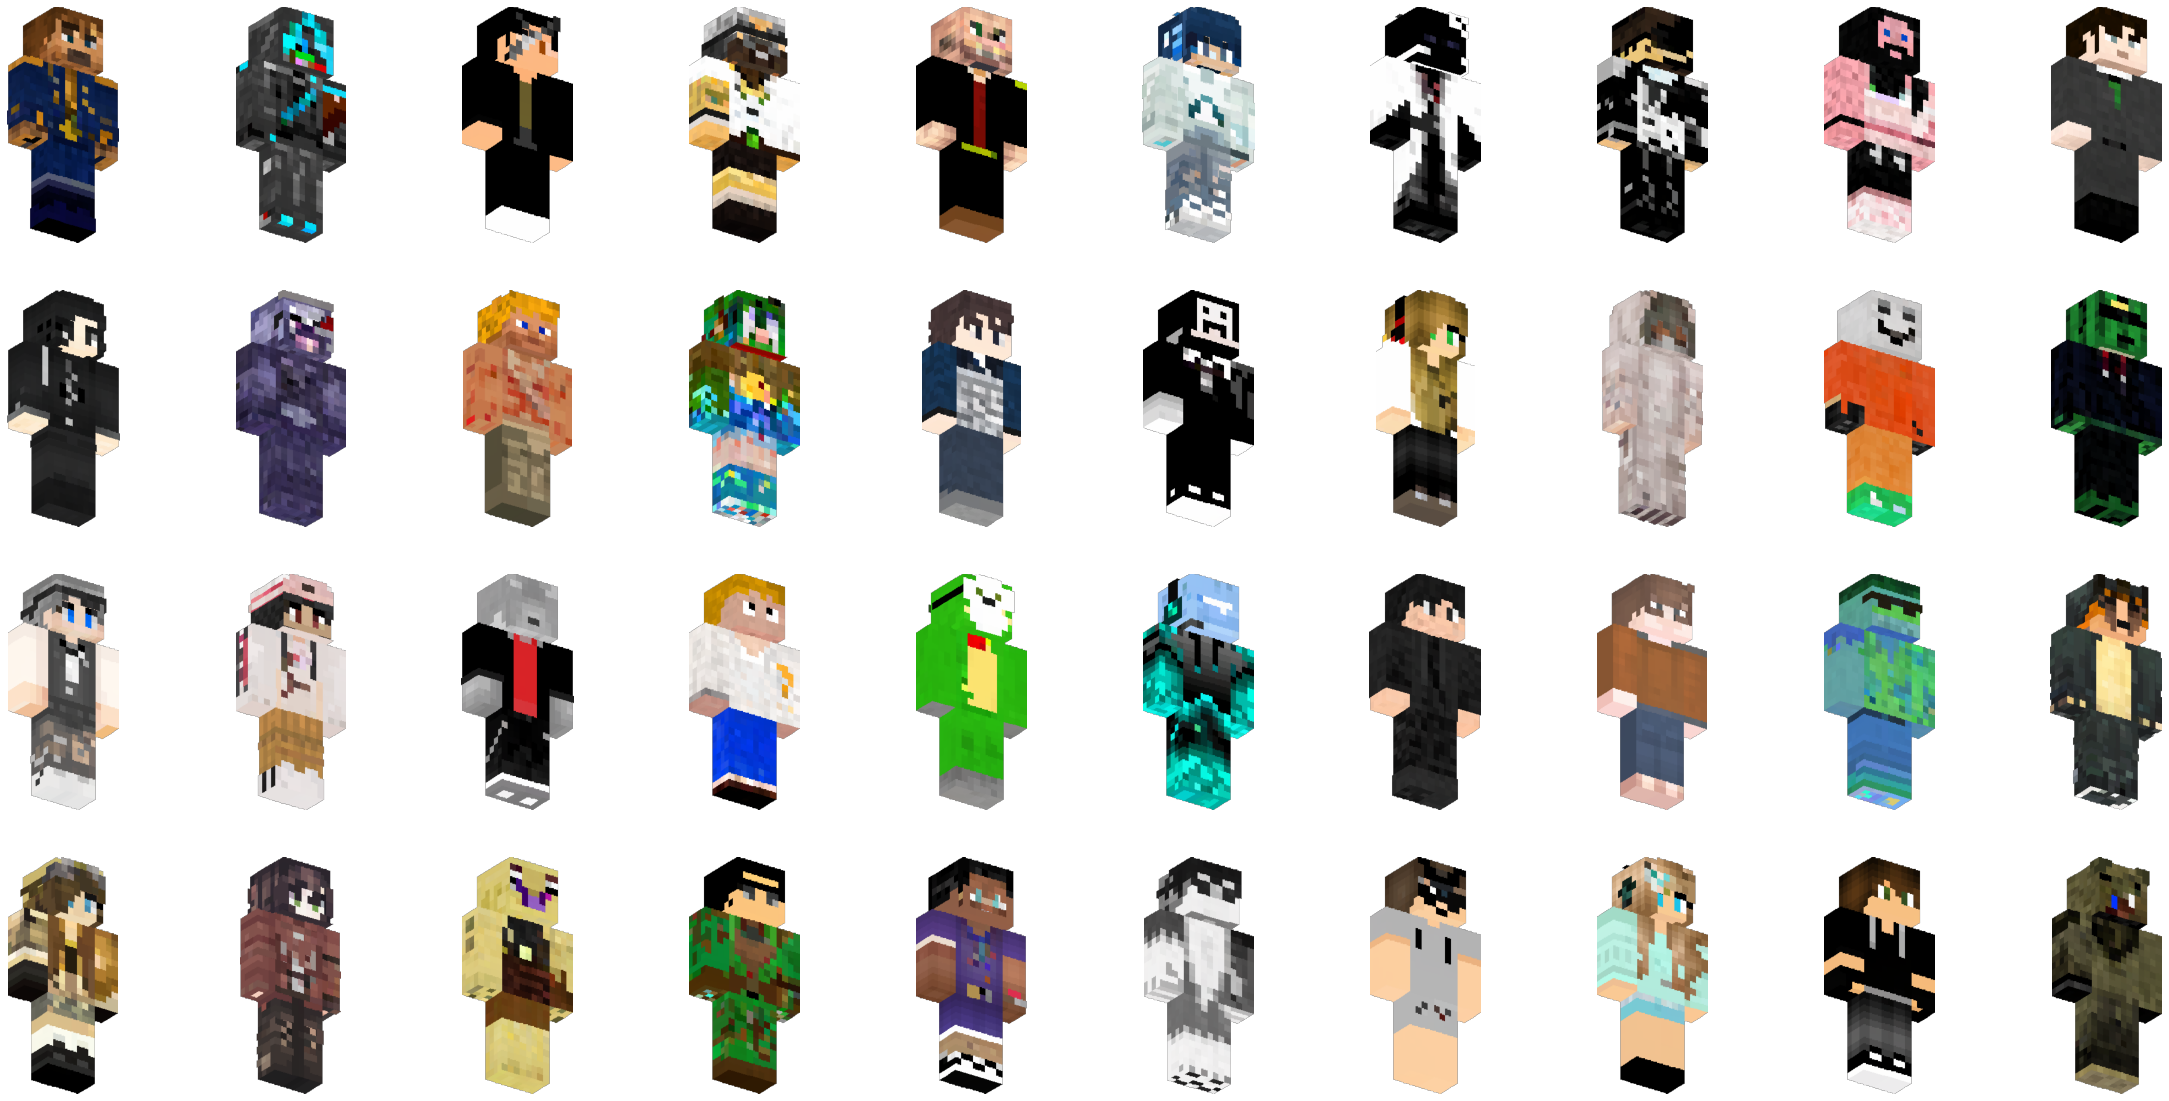

In [12]:
plt.figure(figsize=(40, 20))
d = True
th = 0.5
preprocessed = postprocess(images, th)
for i in range(BATCH_SIZE):
    raw_skin = Image.fromarray(preprocessed[i])
    s = Skin(raw_skin=raw_skin)
    await s.render_skin(display_hair=d, display_second_layer=d, display_cape=d)
    plt.subplot(math.ceil(BATCH_SIZE/10),10, i+1)
    plt.imshow(s.skin)
    plt.axis('off')